# Time series fitting

This tutorial demonstrates:

* How to define a model with a periodic parameter
* How to obtain posterior probability distributions
* How to plot the results


## Model

Lets fit a sine model with gaussian measurement errors.

$$ y = A \sin\left(2 \pi \left(\frac{t}{P} + t_0\right)\right) + B + \epsilon $$

where $\epsilon \sim \mathrm{Normal}(0, \sigma)$


In [1]:
import numpy as np
from numpy import sin, pi

def sine_model(t, B, A, P, t0):
    return A * sin((t / P + t0) * 2 * pi) + B


The model has four unknown parameters:

* the signal offset $B$
* the amplitude $A$
* the period $P$
* the time offset $t_0$

## Generating data

Lets generate some data following this model:


In [2]:
np.random.seed(42)

n_data = 20

# time of observations
t = np.random.uniform(0, 5, size=n_data)

# measurement values
yerr = 1.0
y = np.random.normal(sine_model(t, A=4.2, P=3, t0=0, B=1.0), yerr)


## Visualise the data

Lets plot the data first to see what is going on:

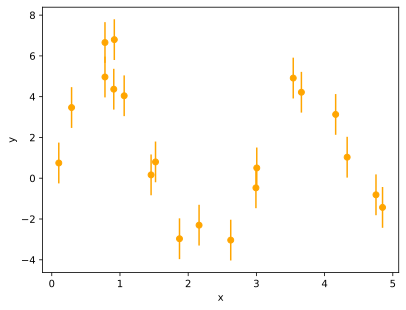

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange');

A beautiful noisy data set, but we can see the modulation.

Now the question is: what model parameters are allowed under these data?

First, we need to define the parameter ranges through a prior:

In [4]:
parameters = ['B', 'A', 'P', '$t_0$']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.01 to 100
    params[1] = 10**(cube[1] * 4 - 2)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params


Define the likelihood, which measures how far the data are from the model predictions.
More precisely, how often the parameters would arise under the given parameters.
We assume gaussian measurement errors of known size (yerr).

$$\chi^2 = \sum\left(\frac{m_i-y_i}{\sigma}\right)^2 $$
$$\log \cal{L} = -\chi^2 / 2$$

where the model is the sine_model function from above at time $t_i$.

In [5]:
import scipy.stats

def log_likelihood(params):
    # unpack the current parameters:
    B, A, P, t0 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model(t, A=A, B=B, P=P, t0=t0)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike
    


Implicitly, this model assumes that the bulge mass is predicted by the black hole mass.
Alternatively, one could flip the axes, or define the scatter orthogonally, 
but lets stick with our approach for now.


Solve the problem:

In [6]:
from ultranest import ReactiveNestedSampler

sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform,
    wrapped_params=[False, False, False, True],
)

In [7]:
result = sampler.run(min_num_live_points=400, dKL=np.inf, min_ess=100)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  


[ultranest] Likelihood function evaluations: 54897


[ultranest]   logZ = -23.02 +- 0.1394


[ultranest] Effective samples strategy satisfied (ESS = 2186.8, need >100)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <inf nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.34, need <0.5)


[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50


[ultranest] done iterating.


We can summarize the parameter constraints and logZ value:

In [8]:
sampler.print_results()


logZ = -23.012 +- 0.290
  single instance: logZ = -23.012 +- 0.182
  bootstrapped   : logZ = -23.021 +- 0.290
  tail           : logZ = +- 0.010

    B                   0.67 +- 0.26
    A                   4.37 +- 0.36
    P                   2.998 +- 0.071
    $t_0$               0.63 +- 0.46


## Plot the parameter posterior probability distribution

A classic corner plot:

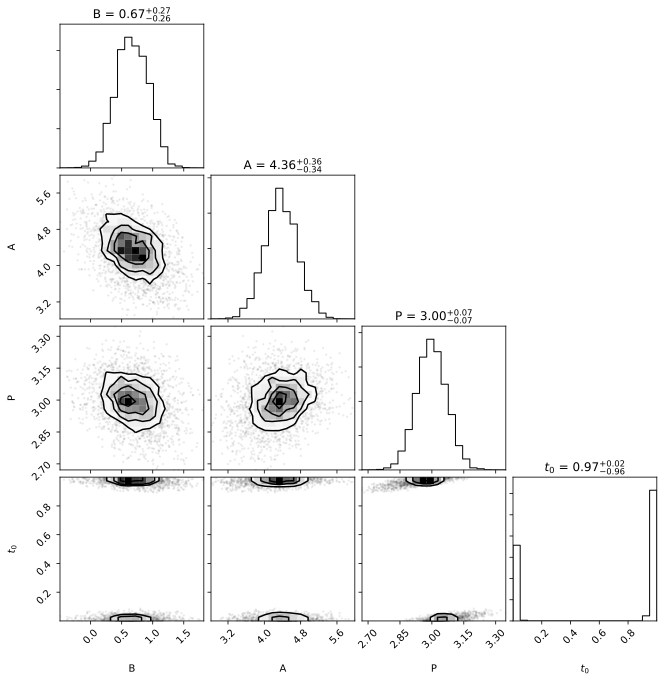

In [9]:
from ultranest.plot import cornerplot
cornerplot(result)

## Plot the fit:

To evaluate whether the results make any sense, we want
to look whether the fitted function goes through the data points.

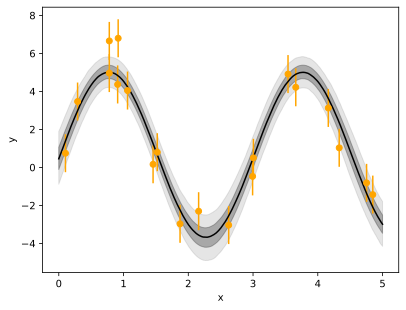

In [10]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A, P, t0 in sampler.results['samples']:
    # compute for each time the y value
    band.add(sine_model(t_grid, A=A, B=B, P=P, t0=t0))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)



## Trace plot

Finally, to understand the structure of the problem and possible multi-modality,
we can use a nested sampling trace plot to look at the history of the exploration.

The trace plot below shows one parameter per panel.
Sampling progresses from the left (entire prior volume) to the right, in the left panel. More and more of the full range is excluded.
The right panels show the marginal posterior distribution.

In [11]:
sampler.plot_trace()